# Prepare (Glass + Gunshot) / 准备（玻璃+枪声）

Load multi-source meta, clean and resample all audio to 22.05k mono, then proceed to folds, analysis, and window planning. 读取多源 meta，清洗后重采样为22.05k单声道，继续分折、分析与分窗规划。

## Imports / 导入

In [1]:
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import re
from IPython.display import Audio, display
from src.meta_utils import load_meta_files, map_canonical_labels, deduplicate_meta, sample_gunshot_even, stratified_folds
from src.viz import plot_wave_and_mel
from src.cache_utils import build_cache_index, GLASS_PIPELINE_PLAN
from src.datasets import balance_folds
from src.augment_pipeline import run_pipeline, PIPELINE_REGISTRY
from src.data_utils import load_audio, generate_aligned_windows, trim_silence, log_mel_spectrogram
from src.config import TARGET_LABELS, POSITIVE_LABELS, SEED, SR, PROJECT_ROOT, N_MELS, HOP_LENGTH, BACKGROUND_LABEL, CACHE_ROOT, CACHE_MEL64, META_FILES, RAW_AUDIO_ROOTS, WINDOW_PARAMS


## Config Override / 配置覆写
Set parameters for this run; defaults can move into config later. 设定本次流程参数，后续可移入 config 默认。

In [2]:
META_FILES = META_FILES  # from config
LABEL_MAP = POSITIVE_LABELS
K_FOLDS = 5
RATIOS = {'glass': 3, 'gunshot': 3, 'background': 4}
MAX_DURATION = 6.0  # seconds
GUNSHOT_TARGET = 90  # total gunshot clips after sampling
TARGET_SR = SR
RESAMPLED_ROOT = CACHE_ROOT / 'data_resampled'
INCLUDE_SOURCES = ['esc50', 'gunshot_kaggle']
TARGET_FRAMES = 84

## Load, map, dedup / 读取映射去重
- Load meta CSVs
- Map raw labels to canonical labels
- Deduplicate by md5/filepath
- Summary counts

读取 meta，映射标签，按 md5/路径去重，打印汇总。

In [3]:
meta_df = load_meta_files(META_FILES)
meta_df = map_canonical_labels(meta_df, label_map=LABEL_MAP, target_labels=TARGET_LABELS)
meta_df = deduplicate_meta(meta_df, subset=['md5','filepath'])
print('Total rows after dedup:', len(meta_df))
print('By source (all):', meta_df['source'].value_counts().to_dict(),'\n')

INCLUDE_SOURCES = ['esc50', 'gunshot_kaggle']
working_df = meta_df[meta_df['source'].isin(INCLUDE_SOURCES)].copy()
holdout_df = meta_df[~meta_df['source'].isin(INCLUDE_SOURCES)].copy()
print('Working sources:', INCLUDE_SOURCES, '->', working_df['source'].value_counts().to_dict())
print('Working labels:', working_df['canonical_label'].value_counts().to_dict())
print('Holdout sources:', holdout_df['source'].value_counts().to_dict())
print('Holdout labels:', holdout_df['canonical_label'].value_counts().to_dict())


Total rows after dedup: 2870
By source (all): {'esc50': 2000, 'gunshot_kaggle': 851, 'freesound': 19} 

Working sources: ['esc50', 'gunshot_kaggle'] -> {'esc50': 2000, 'gunshot_kaggle': 851}
Working labels: {'gunshot': 851, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 

## Filter & gunshot sampling / 过滤与枪声抽样
- Drop clips longer than MAX_DURATION
- Evenly sample gunshot across weapon_id to total GUNSHOT_TARGET

过滤 >MAX_DURATION；枪声按 weapon_id 均匀抽样，总数 GUNSHOT_TARGET。

In [4]:
clean_df = working_df[working_df['duration_sec'] <= MAX_DURATION].copy()
gun_sampled = sample_gunshot_even(clean_df, target_label='gunshot', total=GUNSHOT_TARGET, seed=SEED)
if not gun_sampled.empty:
    gun_stats = gun_sampled.groupby('source').size().to_dict()
    weapon_stats = gun_sampled.apply(lambda r: Path(str(r.get('filepath',''))).parent.name, axis=1).value_counts().to_dict()
    print('Gunshot sampled per source:', gun_stats)
    print('Gunshot sampled per weapon_id (from parent folder):', weapon_stats, '\n')
    
non_gun = clean_df[clean_df['canonical_label'] != 'gunshot']
clean_df = pd.concat([non_gun, gun_sampled], ignore_index=True)
print(f'Label counts: （{len(clean_df)})', clean_df['canonical_label'].value_counts().to_dict())



Gunshot sampled per source: {'gunshot_kaggle': 90}
Gunshot sampled per weapon_id (from parent folder): {'AK-12': 10, 'AK-47': 10, 'IMI Desert Eagle': 10, 'M16': 10, 'M249': 10, 'M4': 10, 'MG-42': 10, 'MP5': 10, 'Zastava M92': 10} 

Label counts: （2090) {'gunshot': 90, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboa

## Resample to 22.05k mono / 重采样为22.05k单声道
Write resampled audio to cache/data_resampled and build resampled_df. 将重采样音频写到 cache/data_resampled，并生成 resampled_df。
⚠️ Loads & writes all clips; may take time/disk. 需加载并写出全部音频，耗时且占用磁盘。

In [5]:
RESAMPLED_ROOT = RESAMPLED_ROOT
resampled_rows = []
for _, r in clean_df.iterrows():
    y_rs, sr_rs = load_audio(r, sr=TARGET_SR)
    rel = Path(r['filepath'])
    if rel.is_absolute():
        rel = rel.relative_to(PROJECT_ROOT)
    dst_path = RESAMPLED_ROOT / rel
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    y_int16 = (y_rs * 32767).clip(-32768, 32767).astype('int16')
    with wave.open(dst_path.as_posix(), 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(TARGET_SR)
        wf.writeframes(y_int16.tobytes())
    frames = len(y_int16)
    resampled_rows.append({
        'sno': r.get('sno', len(resampled_rows)+1),
        'raw_filepath': rel.as_posix(),
        'filepath': dst_path.relative_to(PROJECT_ROOT).as_posix(),
        'label': r.get('label'),
        'canonical_label': r.get('canonical_label'),
        'source': r.get('source'),
        'fold_id': r.get('fold_id',''),
        'duration_sec': round(frames / TARGET_SR, 3),
        'duration_samples': frames,
        'sr': TARGET_SR,
        'channels': 1,
        'bit_depth': 16,
        'md5': '',
        'extra_meta': r.get('extra_meta',''),
    })
resampled_df = pd.DataFrame(resampled_rows)
resampled_df['target_label'] = resampled_df['canonical_label']
print('Resampled rows:', len(resampled_df))
print('sr/ch after resample:', resampled_df['sr'].unique(), resampled_df['channels'].unique())
print('Label counts:', resampled_df['target_label'].value_counts().to_dict())


Resampled rows: 2090
sr/ch after resample: [22260] [1]
Label counts: {'gunshot': 90, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'crackling_fire': 40}


In [6]:
# Optional: save holdout meta for later use
if len(holdout_df) > 0:
    holdout_path = RESAMPLED_ROOT / 'holdout_meta.csv'
    holdout_path.parent.mkdir(parents=True, exist_ok=True)
    holdout_df.to_csv(holdout_path, index=False)
    print('Saved holdout meta to', holdout_path)


Saved holdout meta to /workspace/cache/data_resampled/holdout_meta.csv


## Listen: before vs after / 试听前后
Play original vs resampled audio for a few samples. 对比播放原始与重采样音频。

In [7]:
samples = resampled_df.sample(n=min(5, len(resampled_df)), random_state=SEED)
for _, r in samples.iterrows():
    y_after, sr_after = load_audio(r, sr=TARGET_SR)
    raw_rel = Path(r.get('raw_filepath', r['filepath']))
    raw_path = PROJECT_ROOT / raw_rel if not raw_rel.is_absolute() else raw_rel
    y_before, sr_before = (None, None)
    if raw_path.exists():
        y_before, sr_before = load_audio({'filepath': raw_path}, sr=None)
    print('Sample:', r.get('target_label',''), '|', raw_rel)
    if y_before is not None:
        display(Audio(y_before, rate=sr_before))
    display(Audio(y_after, rate=sr_after))
    print('-'*40)


Sample: pouring_water | data/esc50/audio/3-108451-B-17.wav


----------------------------------------
Sample: drinking_sipping | data/esc50/audio/4-210593-A-29.wav


----------------------------------------
Sample: clock_tick | data/esc50/audio/2-134700-A-38.wav


----------------------------------------
Sample: siren | data/esc50/audio/2-70939-A-42.wav


----------------------------------------
Sample: drinking_sipping | data/esc50/audio/2-102581-A-29.wav


----------------------------------------


## 给 Audio 进行分折
- 在audio层进行分折，可以避免同一个audio切窗之后混入不同的 fold


In [8]:
folded_df = stratified_folds(resampled_df, k=K_FOLDS, seed=SEED, group_key='canonical_label', sub_key='weapon', fold_column='fold_id')
print('Fold distribution (counts):', folded_df['fold_id'].value_counts().to_dict())
fold_pivot = folded_df.pivot_table(index='target_label', columns='fold_id', values='filepath', aggfunc='count').fillna(0).astype(int)
print('Label x fold (counts):')
display(fold_pivot)

# 从 extra_meta 中提取 weapon_id=XXXX 的值
def parse_weapon(extra: str) -> str:
    if not isinstance(extra, str):
        return "unknown"
    m = re.search(r"weapon_id=([^,;]+)", extra)
    return m.group(1).strip() if m else "unknown"

gun_df = folded_df[folded_df['canonical_label'] == 'gunshot'].copy()
gun_df["weapon"] = gun_df["extra_meta"].apply(parse_weapon)
weapon_fold = gun_df.pivot_table(
    index="weapon",
    columns="fold_id",
    values="filepath",
    aggfunc="count",
    fill_value=0
).astype(int)
print("\nWeapon x fold (counts):")
display(weapon_fold)


Fold distribution (counts): {3: 418, 5: 418, 4: 418, 2: 418, 1: 418}
Label x fold (counts):


fold_id            1   2   3   4   5
target_label                        
airplane           8   8   8   8   8
breathing          8   8   8   8   8
brushing_teeth     8   8   8   8   8
can_opening        8   8   8   8   8
car_horn           8   8   8   8   8
cat                8   8   8   8   8
chainsaw           8   8   8   8   8
chirping_birds     8   8   8   8   8
church_bells       8   8   8   8   8
clapping           8   8   8   8   8
clock_alarm        8   8   8   8   8
clock_tick         8   8   8   8   8
coughing           8   8   8   8   8
cow                8   8   8   8   8
crackling_fire     8   8   8   8   8
crickets           8   8   8   8   8
crow               8   8   8   8   8
crying_baby        8   8   8   8   8
dog                8   8   8   8   8
door_wood_creaks   8   8   8   8   8
door_wood_knock    8   8   8   8   8
drinking_sipping   8   8   8   8   8
engine             8   8   8   8   8
fireworks          8   8   8   8   8
footsteps          8   8   8   8   8
frog               8   8   8   8   8
glass              8   8   8   8   8
gunshot           18  18  18  18  18
hand_saw           8   8   8   8   8
helicopter         8   8   8   8   8
hen                8   8   8   8   8
insects            8   8   8   8   8
keyboard_typing    8   8   8   8   8
laughing           8   8   8   8   8
mouse_click        8   8   8   8   8
pig                8   8   8   8   8
pouring_water      8   8   8   8   8
rain               8   8   8   8   8
rooster            8   8   8   8   8
sea_waves          8   8   8   8   8
sheep              8   8   8   8   8
siren              8   8   8   8   8
sneezing           8   8   8   8   8
snoring            8   8   8   8   8
thunderstorm       8   8   8   8   8
toilet_flush       8   8   8   8   8
train              8   8   8   8   8
vacuum_cleaner     8   8   8   8   8
washing_machine    8   8   8   8   8
water_drops        8   8   8   8   8
wind               8   8   8   8   8


Weapon x fold (counts):


fold_id           1  2  3  4  5
weapon                         
AK-12             2  2  2  2  2
AK-47             2  2  2  2  2
IMI Desert Eagle  2  2  2  2  2
M16               2  2  2  2  2
M249              2  2  2  2  2
M4                2  2  2  2  2
MG-42             2  2  2  2  2
MP5               2  2  2  2  2
Zastava M92       2  2  2  2  2

### Detailed energy/peak stats / 能量与峰值细查 (统计峰值位置、活跃占比，辅助判断窗口/裁剪参数)。

Energy detail (mean/median/95%)


duration                      rms_max                        peak_pos  \
            mean median _quantile95      mean    median _quantile95      mean   
label                                                                           
glass     5.0000    5.0         5.0  0.210408  0.170229    0.776704  0.150000   
gunshot   1.8625    2.0         2.0  0.219596  0.211739    0.431921  0.457292   

                           active_ratio                        
        median _quantile95         mean    median _quantile95  
label                                                          
glass      0.1       0.605     0.190909  0.181818    0.459091  
gunshot    0.5       0.750     0.655238  0.600000    1.000000

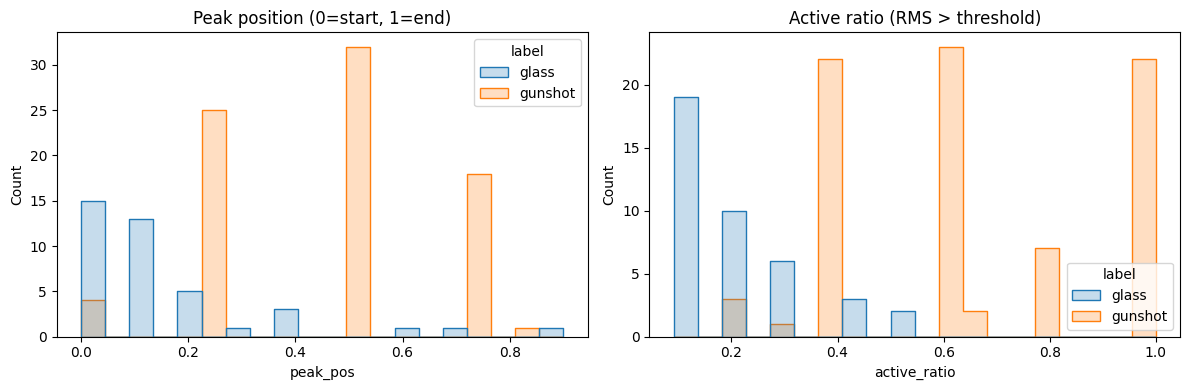

In [9]:
from functools import partial

# Defaults if config cell not run yet
WINDOW_SECONDS = globals().get('WINDOW_SECONDS', 1.0)
WINDOW_HOP = globals().get('WINDOW_HOP', 0.5)
ENERGY_THRESHOLD = globals().get('ENERGY_THRESHOLD', 0.3)
TRIM_SILENCE_BEFORE = globals().get('TRIM_SILENCE_BEFORE', False)
TRIM_TOP_DB = globals().get('TRIM_TOP_DB', 20.0)
TRIM_MIN_KEEP_SECONDS = globals().get('TRIM_MIN_KEEP_SECONDS', 0.0)


def _quantile95(x):
    return x.quantile(0.95)

def compute_energy_detail(sub_df, sample_n=80):
    rows = []
    if len(sub_df) == 0:
        return pd.DataFrame(rows)
    sample = sub_df.sample(n=min(sample_n, len(sub_df)), random_state=SEED)
    for _, r in sample.iterrows():
        y, sr = load_audio(r, sr=TARGET_SR)
        if TRIM_SILENCE_BEFORE:
            y = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
        frame_length = min(2048, int(WINDOW_SECONDS * sr))
        hop = int(WINDOW_HOP * sr)
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop)[0]
        if rms.size == 0 or rms.max() <= 0:
            continue
        peak_idx = int(np.argmax(rms))
        peak_pos = peak_idx / max(len(rms) - 1, 1)
        active_ratio = float((rms > (rms.max() * ENERGY_THRESHOLD)).sum()) / len(rms)
        rows.append({
            'duration': len(y) / sr,
            'rms_max': float(rms.max()),
            'peak_pos': peak_pos,
            'active_ratio': active_ratio,
        })
    return pd.DataFrame(rows)

energy_detail = []
for lbl in ['glass', 'gunshot']:
    df_lbl = folded_df[folded_df['target_label'] == lbl]
    stats = compute_energy_detail(df_lbl)
    stats['label'] = lbl
    energy_detail.append(stats)
energy_detail = pd.concat(energy_detail, ignore_index=True)
print('Energy detail (mean/median/95%)')
display(energy_detail.groupby('label')[['duration', 'rms_max', 'peak_pos', 'active_ratio']].agg(['mean', 'median', _quantile95]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=energy_detail, x='peak_pos', hue='label', bins=20, ax=axes[0], element='step')
axes[0].set_title('Peak position (0=start, 1=end)')
sns.histplot(data=energy_detail, x='active_ratio', hue='label', bins=20, ax=axes[1], element='step')
axes[1].set_title('Active ratio (RMS > threshold)')
plt.tight_layout(); plt.show()


## Window config / 分窗配置
Override window/threshold parameters for this session. 本次会话窗口/阈值参数。

In [10]:
WINDOW_SECONDS = 1.0
WINDOW_HOP = 0.5
ENERGY_THRESHOLD = 0.3
PEAK_RATIO_THRESHOLD = 0.8
FRONT_PEAK_RATIO = 0.5
EXTRA_SHIFTS = (-0.1, 0.1)
TRIM_SILENCE_BEFORE = True
TRIM_TOP_DB = 20.0
TRIM_MIN_KEEP_SECONDS = 0.2
cfg_rows = [
    ('WINDOW_SECONDS', WINDOW_SECONDS, 'window length (s): longer=more context, shorter=less latency but may miss long events'),
    ('WINDOW_HOP', WINDOW_HOP, 'hop (s): smaller=denser windows, larger=fewer windows/less overlap'),
    ('ENERGY_THRESHOLD', ENERGY_THRESHOLD, 'energy mask threshold (relative): higher=drop quiet windows, lower=keep more'),
    ('PEAK_RATIO_THRESHOLD', PEAK_RATIO_THRESHOLD, 'peak energy ratio (relative to clip): higher=only strong peaks kept'),
    ('FRONT_PEAK_RATIO', FRONT_PEAK_RATIO, 'peak position limit (0-1): lower=peaks must be earlier'),
    ('EXTRA_SHIFTS', EXTRA_SHIFTS, 'fallback shifts (s) when no peak windows kept'),
    ('TRIM_SILENCE_BEFORE', TRIM_SILENCE_BEFORE, 'apply silence trim before windowing'),
    ('TRIM_TOP_DB', TRIM_TOP_DB, 'trim threshold dB: higher=more aggressive trimming'),
    ('TRIM_MIN_KEEP_SECONDS', TRIM_MIN_KEEP_SECONDS, 'min segment kept after trim (s)')
]
print('Windowing / energy config:')
for k,v,desc in cfg_rows:
    print(f'- {k}: {v} -> {desc}')


Windowing / energy config:
- WINDOW_SECONDS: 1.0 -> window length (s): longer=more context, shorter=less latency but may miss long events
- WINDOW_HOP: 0.5 -> hop (s): smaller=denser windows, larger=fewer windows/less overlap
- ENERGY_THRESHOLD: 0.3 -> energy mask threshold (relative): higher=drop quiet windows, lower=keep more
- PEAK_RATIO_THRESHOLD: 0.8 -> peak energy ratio (relative to clip): higher=only strong peaks kept
- FRONT_PEAK_RATIO: 0.5 -> peak position limit (0-1): lower=peaks must be earlier
- EXTRA_SHIFTS: (-0.1, 0.1) -> fallback shifts (s) when no peak windows kept
- TRIM_SILENCE_BEFORE: True -> apply silence trim before windowing
- TRIM_TOP_DB: 20.0 -> trim threshold dB: higher=more aggressive trimming
- TRIM_MIN_KEEP_SECONDS: 0.2 -> min segment kept after trim (s)


## Base window summary / 基础分窗统计
Generate aligned windows for glass & gunshot, count per clip. 对玻璃/枪声分窗，统计每clip窗口数。

In [11]:

# all_labels = labels_for_align + [BACKGROUND_LABEL]
# print(all_labels)
# display(folded_df[folded_df['target_label'].isin(all_labels)])

In [12]:
records = []
labels_for_align = ['glass', 'gunshot']
all_labels = sorted(folded_df['target_label'].unique().tolist())
subset = folded_df[folded_df['target_label'].isin(all_labels)]
for _, row in subset.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=labels_for_align,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    records.append({
        'label': row['target_label'],
        'fold': row.get('fold_id', -1),
        'clip': Path(row['filepath']).stem,
        'n_windows': len(wins),
    })
base_df = pd.DataFrame(records)

# 简单键值统计：每类多少个窗口
if base_df.empty:
    print('No windows found')
else:
    total_windows = int(base_df['n_windows'].sum())
    print(f"Total clips: {len(base_df)}, total windows: {total_windows}")
    label_windows = base_df.groupby('label')['n_windows'].sum().reindex(all_labels, fill_value=0)
    print("\nWindows per label:")
    for lbl, cnt in label_windows.to_dict().items():
        print(f"  {lbl}: {int(cnt)}")

    if 'fold' in base_df.columns:
        fold_totals = base_df.pivot_table(index='fold', columns='label', values='n_windows', aggfunc='sum').fillna(0)
        print("\nWindows per fold x label (total windows):")
        display(fold_totals)


Total clips: 2090, total windows: 9749

Windows per label:
  airplane: 309
  breathing: 134
  brushing_teeth: 262
  can_opening: 50
  car_horn: 177
  cat: 109
  chainsaw: 256
  chirping_birds: 222
  church_bells: 299
  clapping: 257
  clock_alarm: 263
  clock_tick: 162
  coughing: 63
  cow: 155
  crackling_fire: 251
  crickets: 315
  crow: 219
  crying_baby: 134
  dog: 84
  door_wood_creaks: 156
  door_wood_knock: 72
  drinking_sipping: 81
  engine: 320
  fireworks: 95
  footsteps: 160
  frog: 195
  glass: 56
  gunshot: 133
  hand_saw: 214
  helicopter: 326
  hen: 132
  insects: 222
  keyboard_typing: 172
  laughing: 135
  mouse_click: 122
  pig: 150
  pouring_water: 157
  rain: 345
  rooster: 68
  sea_waves: 285
  sheep: 203
  siren: 295
  sneezing: 40
  snoring: 109
  thunderstorm: 162
  toilet_flush: 210
  train: 320
  vacuum_cleaner: 331
  washing_machine: 339
  water_drops: 94
  wind: 329

Windows per fold x label (total windows):


label  airplane  breathing  brushing_teeth  can_opening  car_horn  cat  \
fold                                                                     
1            62         16              48            9        26   18   
2            54         28              52           12        34   27   
3            63         20              50            8        44   22   
4            65         34              44            9        37   17   
5            65         36              68           12        36   25   

label  chainsaw  chirping_birds  church_bells  clapping  ...  siren  sneezing  \
fold                                                     ...                    
1            57              42            52        50  ...     59         8   
2            51              40            60        51  ...     62         8   
3            47              52            71        56  ...     62         8   
4            53              42            61        47  ...     49         8   
5            48              46            55        53  ...     63         8   

label  snoring  thunderstorm  toilet_flush  train  vacuum_cleaner  \
fold                                                                
1           17            40            46     67              71   
2           23            33            33     65              66   
3           25            30            45     60              67   
4           21            31            37     67              60   
5           23            28            49     61              67   

label  washing_machine  water_drops  wind  
fold                                       
1                   71           14    70  
2                   70           10    69  
3                   58           11    70  
4                   68           29    59  
5                   72           30    61  

[5 rows x 51 columns]

## Window QA visualization / 分窗可视化QA
Plot waveform+RMS with kept window boundaries for one glass and one gunshot sample. 对玻璃/枪声各选一条，画波形+RMS并标出保留的窗口边界。



=== Sample 1: glass | esc50 | cache/data_resampled/data/esc50/audio/5-260433-A-39.wav
Full clip (5.00s)


start_sec  end_sec  peak_ratio  peak_position  status  \
0        NaN      NaN         NaN            NaN    info   
1   0.276011      5.0         NaN            NaN  remove   
2   0.000000      1.0         1.0       0.001887    keep   

                                              reason  
0  len_raw=5.000s len_trim=0.276s lead_trim=0.000...  
1                                   silent_trim_tail  
2                                               pass

Length raw=5.00s after_trim=0.28s


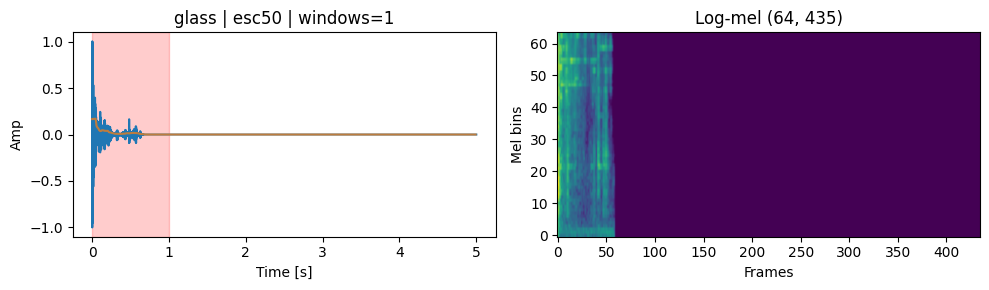

Play window 0: 0.00s - 1.00s



=== Sample 2: gunshot | gunshot_kaggle | cache/data_resampled/data/gunshot_kaggle/M16/5 (5).wav
Full clip (2.00s)


start_sec  end_sec  peak_ratio  peak_position status  \
0        NaN      NaN         NaN            NaN   info   
1        0.0      1.0    1.000000       0.000045   keep   
2        0.5      1.5    0.975503       0.982615   skip   
3        1.0      2.0    0.976365       0.738724   skip   

                                              reason  
0  len_raw=2.000s len_trim=2.000s lead_trim=0.000...  
1                                               pass  
2                                          late_peak  
3                                          late_peak

Length raw=2.00s after_trim=1.56s


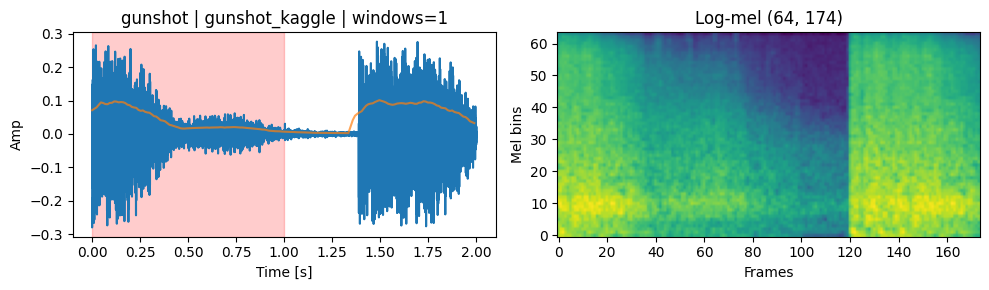

Play window 0: 0.00s - 1.00s



=== Sample 3: siren | esc50 | cache/data_resampled/data/esc50/audio/4-111671-B-42.wav
Full clip (5.00s)


start_sec  end_sec peak_ratio peak_position status  \
0        NaN      NaN       None          None   info   
1        0.0      1.0       None          None   keep   
2        0.5      1.5       None          None   keep   
3        1.0      2.0       None          None   keep   
4        1.5      2.5       None          None   keep   
5        2.0      3.0       None          None   keep   
6        2.5      3.5       None          None   keep   
7        3.0      4.0       None          None   keep   
8        3.5      4.5       None          None   keep   
9        4.0      5.0       None          None   keep   

                                              reason  
0  len_raw=5.000s len_trim=5.000s lead_trim=0.000...  
1                                               pass  
2                                               pass  
3                                               pass  
4                                               pass  
5                                               pass  
6                                               pass  
7                                               pass  
8                                               pass  
9                                               pass

Length raw=5.00s after_trim=5.00s


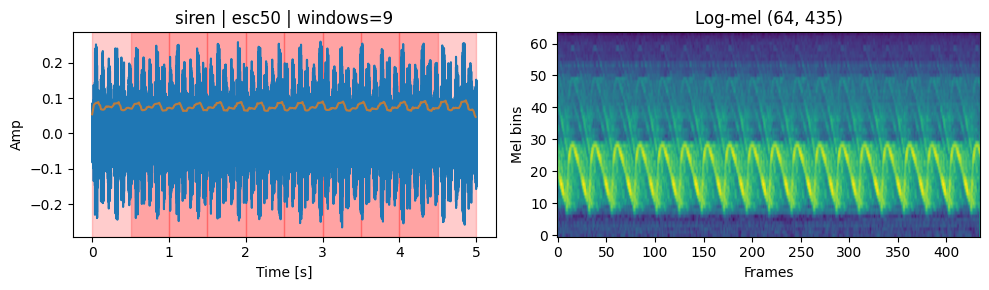

Play window 0: 0.00s - 1.00s


Play window 1: 0.50s - 1.50s


Play window 2: 1.00s - 2.00s


Play window 3: 1.50s - 2.50s


Play window 4: 2.00s - 3.00s


Play window 5: 2.50s - 3.50s


Play window 6: 3.00s - 4.00s


Play window 7: 3.50s - 4.50s


Play window 8: 4.00s - 5.00s


In [13]:
SEED = 5


## Window QA (combined viz + listening) / 分窗 QA（可视化+试听）
# Sample one glass, one gunshot, one background (if available); visualize windows and listen to kept windows.
samples_cfg = ['glass','gunshot', BACKGROUND_LABEL]
samples = []
for lbl in samples_cfg:
    subset = folded_df[folded_df['target_label']==lbl]
    if len(subset) == 0:
        continue
    samples.append(subset.sample(random_state=SEED).iloc[0])
if not any(s.get('target_label') == BACKGROUND_LABEL for s in samples):
    bg_pool = folded_df[~folded_df['target_label'].isin(['glass','gunshot'])]
    if len(bg_pool) > 0:
        samples.append(bg_pool.sample(random_state=SEED).iloc[0])
if len(samples) == 0:
    print('No samples available for QA')
else:
    for idx, row in enumerate(samples):
        print(f"\n=== Sample {idx+1}: {row.get('target_label','')} | {row.get('source','')} | {row.get('filepath','')}")
        y, sr = load_audio(row, sr=TARGET_SR)
        print(f"Full clip ({len(y)/sr:.2f}s)")
        display(Audio(y, rate=sr))
        # 记录窗口决策日志
        logs = []
        wins = generate_aligned_windows(
            row,
            align_labels=['glass','gunshot'],
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            label_params=WINDOW_PARAMS,
            debug=True,
            debug_sink=logs,
        )
        # 打印日志表，便于查看被丢弃原因
        if logs:
            import pandas as pd
            display(pd.DataFrame(logs))
        # 记录修剪前后长度
        if TRIM_SILENCE_BEFORE:
            y_trim = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
            print(f"Length raw={len(y)/sr:.2f}s after_trim={len(y_trim)/sr:.2f}s")
        hop_len = int(WINDOW_HOP * sr)
        win_len = int(WINDOW_SECONDS * sr)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        times = np.arange(len(y)) / sr
        axes[0].plot(times, y)
        axes[0].set_title(f"{row['target_label']} | {row['source']} | windows={len(wins)}")
        axes[0].set_xlabel('Time [s]')
        axes[0].set_ylabel('Amp')
        rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
        rms_times = (np.arange(len(rms)) * 256) / sr
        axes[0].plot(rms_times, rms, alpha=0.7)
        # 使用日志中的 start_sec 标记被保留的窗口
        kept_starts = [l['start_sec'] for l in logs if l.get('status') == 'keep' and l.get('start_sec') is not None]
        for start_sec in kept_starts:
            axes[0].axvspan(start_sec, start_sec + WINDOW_SECONDS, color='red', alpha=0.2)
        mel = log_mel_spectrogram(y, sr, n_fft=HOP_LENGTH*4, hop_length=HOP_LENGTH, n_mels=N_MELS)
        axes[1].imshow(mel, aspect='auto', origin='lower')
        axes[1].set_title(f'Log-mel {mel.shape}')
        axes[1].set_xlabel('Frames')
        axes[1].set_ylabel('Mel bins')
        plt.tight_layout(); plt.show()
        for w_idx, w in enumerate(wins):
            start = kept_starts[w_idx] if w_idx < len(kept_starts) else w_idx * hop_len / sr
            end = start + WINDOW_SECONDS
            print(f"Play window {w_idx}: {start:.2f}s - {end:.2f}s")
            display(Audio(w, rate=sr))


## Play 10 event windows / 播放10个事件窗口
Play up to 10 kept windows (glass/gunshot) for quick QA. 播放最多10个保留窗口，便于快速听检。


In [14]:
clips = folded_df[folded_df['target_label'].isin(['glass','gunshot'])].sample(frac=1.0, random_state=SEED)
played = 0
for _, row in clips.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    for w_idx, w in enumerate(wins):
        print('{} | {} | window {}'.format(row['target_label'], Path(row['filepath']).stem, w_idx))
        display(Audio(w, rate=TARGET_SR))
        played += 1
        if played >= 10:
            break
    if played >= 10:
        break
if played == 0:
    print('No windows to play')

if not wins:
    print('No windows to inspect for shape')
else:
    mel = log_mel_spectrogram(wins[0], sr=TARGET_SR)
    print(f'log-mel shape: {mel.shape}; model input: (batch, 1, {mel.shape[0]}, {mel.shape[1]})')

gunshot | 1 (1) | window 0


gunshot | 6 (66) | window 0


gunshot | 6 (66) | window 1


gunshot | 8 (29) | window 0


gunshot | 8 (29) | window 1


gunshot | 2 (72) | window 0


gunshot | 2 (72) | window 1


gunshot | 9 (58) | window 0


gunshot | 1 (20) | window 0


gunshot | 1 (20) | window 1


log-mel shape: (64, 87); model input: (batch, 1, 64, 87)


## 整合原始window数据

In [15]:
# Build window-level dataframe (one row per window)
window_records = []
labels_for_align = TARGET_LABELS  # 正类对齐峰值，其余走背景逻辑
for _, row in folded_df.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=labels_for_align,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    base_label = row.get('canonical_label', row.get('target_label', 'unknown'))
    mapped_label = base_label if base_label in TARGET_LABELS else BACKGROUND_LABEL
    clip_id = Path(row['filepath']).stem
    for w_idx, w in enumerate(wins):
        start_sec = w_idx * WINDOW_HOP
        end_sec = start_sec + WINDOW_SECONDS
        window_records.append({
            'clip_id': clip_id,
            'window_id': f"w{w_idx}",
            'fold_id': row.get('fold_id', -1),
            'source': row.get('source', ''),
            'orig_label': base_label,
            'target_label': mapped_label,
            'start_sec': start_sec,
            'end_sec': end_sec,
            'length_sec': WINDOW_SECONDS,
            'filepath': row.get('filepath'),
            'raw_filepath': row.get('raw_filepath'),
        })

window_df = pd.DataFrame(window_records)
print(f"Total windows: {len(window_df)}")
label_totals = window_df['target_label'].value_counts().to_dict()
print("Windows per label (total):")
for k, v in label_totals.items():
    print(f"  {k}: {v}")

if 'fold_id' in window_df.columns:
    print("\nFold x label (total windows):")
    pivot = window_df.pivot_table(index='fold_id', columns='target_label', values='window_id', aggfunc='count').fillna(0)
    print(pivot.to_string())


display(window_df[:5])

Total windows: 9749
Windows per label (total):
  background: 9560
  gunshot: 133
  glass: 56

Fold x label (total windows):
target_label  background  glass  gunshot
fold_id                                 
1                   1930     12       26
2                   1880      8       28
3                   1933      8       30
4                   1873     14       25
5                   1944     14       24


clip_id window_id  fold_id source orig_label target_label  start_sec  \
0  5-215445-A-47        w0        3  esc50   airplane   background        0.0   
1  5-215445-A-47        w1        3  esc50   airplane   background        0.5   
2  5-215445-A-47        w2        3  esc50   airplane   background        1.0   
3  5-215445-A-47        w3        3  esc50   airplane   background        1.5   
4  5-215445-A-47        w4        3  esc50   airplane   background        2.0   

   end_sec  length_sec                                           filepath  \
0      1.0         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
1      1.5         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
2      2.0         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
3      2.5         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
4      3.0         1.0  cache/data_resampled/data/esc50/audio/5-215445...   

                         raw_filepath  
0  data/esc50/audio/5-215445-A-47.wav  
1  data/esc50/audio/5-215445-A-47.wav  
2  data/esc50/audio/5-215445-A-47.wav  
3  data/esc50/audio/5-215445-A-47.wav  
4  data/esc50/audio/5-215445-A-47.wav

## Augment plan & cache dirs / 增强计划与缓存目录
设定 pipeline、对齐标签、Smoke/Full 输出目录。

In [16]:
PIPELINE_PLAN = GLASS_PIPELINE_PLAN
# ALIGN_LABELS = CACHE_ALIGN_LABELS
SMOKE_CACHE_DIR = CACHE_MEL64 / 'mel64_smoke_multi'
FULL_CACHE_DIR = CACHE_MEL64 / 'mel64_multi'
SMOKE_COUNTS = {'glass': 10, 'gunshot': 10, 'background': 20}
print('Pipeline:', PIPELINE_PLAN)
print('Smoke dir:', SMOKE_CACHE_DIR)
print('Full dir:', FULL_CACHE_DIR)

# # 如未定义这些参数，给个默认兜底
# EXTRA_SHIFTS = globals().get("EXTRA_SHIFTS", ())
# ENERGY_THRESHOLD = globals().get("ENERGY_THRESHOLD", 0.3)
# PEAK_RATIO_THRESHOLD = globals().get("PEAK_RATIO_THRESHOLD", 0.8)
# FRONT_PEAK_RATIO = globals().get("FRONT_PEAK_RATIO", 0.5)
# TRIM_SILENCE_BEFORE = globals().get("TRIM_SILENCE_BEFORE", True)
# TRIM_TOP_DB = globals().get("TRIM_TOP_DB", 20.0)
# TRIM_MIN_KEEP_SECONDS = globals().get("TRIM_MIN_KEEP_SECONDS", 0.2)

Pipeline: {'shift_gain': {'copies': 2}, 'stretch_reverb': {'copies': 2}, 'shift_mix': {'copies': 2}, 'filter_gain': {'copies': 2}, 'gain_mix': {'copies': 1}, 'stretch_filter': {'copies': 1}}
Smoke dir: /workspace/cache/mel64/mel64_smoke_multi
Full dir: /workspace/cache/mel64/mel64_multi


## Listen: base vs aug (smoke) / 试听增强样本
抽样 glass/gunshot 各 1 条，播放 base 和各 pipeline 增强（mix 会抽背景）。


In [17]:
rng = np.random.default_rng(SEED)
bg_pool = window_df[window_df['target_label'] == BACKGROUND_LABEL]

def sample_bg_chunk(length):
    if bg_pool.empty:
        return None
    row = bg_pool.sample(random_state=SEED).iloc[0]
    y_bg, _ = load_audio(row, sr=TARGET_SR)
    if len(y_bg) < length:
        y_bg = np.pad(y_bg, (0, length - len(y_bg)))
    start = rng.integers(0, max(1, len(y_bg) - length + 1))
    return y_bg[start:start+length]

for lbl in ['glass','gunshot']:
    sub = window_df[window_df['target_label'] == lbl]
    if sub.empty:
        continue
    row = sub.sample(random_state=SEED).iloc[0]
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    wins = generate_aligned_windows(
        row,
        align_labels=labels_for_align,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    if not wins:
        continue
    base = wins[0]
    print(f"Label={lbl} | clip={Path(row['filepath']).stem} | base")
    display(Audio(base, rate=TARGET_SR))
    for name, cfg in PIPELINE_REGISTRY.items():
        bg = None
        if 'mix' in PIPELINE_REGISTRY[name]:
            bg = sample_bg_chunk(len(base))
        aug = run_pipeline(base, name, background=bg)
        print(f" -> {name}")
        display(Audio(aug.audio, rate=TARGET_SR))
    print('-'*40)


Label=glass | clip=1-20133-A-39 | base


 -> stretch_gain


 -> reverb_gain


 -> mix_gain


 -> filter_gain


 -> mix_filter_gain


 -> stretch_mix_gain


 -> stretch_filter_gain


 -> reverb_mix_gain


 -> reverb_filter_gain


 -> stretch_mix_filter_gain


 -> reverb_mix_filter_gain


----------------------------------------
Label=gunshot | clip=2 (1) | base


 -> stretch_gain


 -> reverb_gain


 -> mix_gain


 -> filter_gain


 -> mix_filter_gain


 -> stretch_mix_gain


 -> stretch_filter_gain


 -> reverb_mix_gain


 -> reverb_filter_gain


 -> stretch_mix_filter_gain


 -> reverb_mix_filter_gain


----------------------------------------


## 选出 target window，并使用数据增强扩充

In [18]:
# Augment windows per fold/label (base included), no background mixing
# Assumes PIPELINE_REGISTRY, TARGET_LABELS, WINDOW_PARAMS, TARGET_SR 等已定义
TARGET_PER_FOLD = {'glass': 250, 'gunshot': 250}
plan_names = list(PIPELINE_REGISTRY.keys())
rng = np.random.default_rng(SEED)
aug_records = []

for lab, target in TARGET_PER_FOLD.items():
    for fold, group in folded_df[folded_df['canonical_label'] == lab].groupby('fold_id'):
        win_pool = []
        for _, row in group.iterrows():
            wins = generate_aligned_windows(
                row,
                align_labels=TARGET_LABELS,
                extra_shifts=EXTRA_SHIFTS,
                energy_threshold=ENERGY_THRESHOLD,
                peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
                front_peak_ratio=FRONT_PEAK_RATIO,
                trim_silence_before=TRIM_SILENCE_BEFORE,
                trim_top_db=TRIM_TOP_DB,
                trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
                label_params=WINDOW_PARAMS,
            )
            clip_id = Path(row['filepath']).stem
            for w_idx, w in enumerate(wins):
                win_pool.append((clip_id, w_idx, w, row))
        if not win_pool:
            continue

        # 1) 写入全部 base，不计入 target
        for clip_id, w_idx, w, row in win_pool:
            aug_records.append({
                'clip_id': clip_id,
                'window_id': f"{clip_id}_w{w_idx}",
                'fold_id': fold,
                'source': row.get('source',''),
                'original_label': lab,
                'target_label': lab,
                'pipeline': 'base',
                'copy': 0,
                'length_sec': len(w) / TARGET_SR,
                'audio': w,
            })

        # 2) 增广配额 = target - base_count
        remaining = max(target - len(win_pool), 0)
        if remaining == 0:
            continue

        # 覆盖阶段：每个窗口×每种 pipeline 各至少一次，消耗 remaining
        count = 0
        for clip_id, w_idx, w, row in win_pool:
            for name in plan_names:
                if count >= remaining:
                    break
                bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None  # 若不用混音，设 bg=None
                aug = run_pipeline(w, name, background=bg)
                aug_records.append({
                    'clip_id': clip_id,
                    'window_id': f"{clip_id}_w{w_idx}",
                    'fold_id': fold,
                    'source': row.get('source',''),
                    'original_label': lab,
                    'target_label': lab,
                    'pipeline': name,
                    'copy': 0,
                    'length_sec': len(aug.audio) / TARGET_SR,
                    'audio': aug.audio,
                })
                count += 1
            if count >= remaining:
                break

        # 3) 若仍未达 remaining，随机窗口+随机 pipeline 补齐
        while count < remaining:
            idx = rng.integers(0, len(win_pool))
            clip_id, w_idx, w, row = win_pool[idx]
            name = rng.choice(plan_names)
            bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None  # 若不用混音，设 bg=None
            aug = run_pipeline(w, name, background=bg)
            aug_records.append({
                'clip_id': clip_id,
                'window_id': f"{clip_id}_w{w_idx}",
                'fold_id': fold,
                'source': row.get('source',''),
                'original_label': lab,
                'target_label': lab,
                'pipeline': name,
                'copy': 0,
                'length_sec': len(aug.audio) / TARGET_SR,
                'audio': aug.audio,
            })
            count += 1

aug_df = pd.DataFrame(aug_records)
display(aug_df[:5])

print("\nWindows per fold x target_label x pipeline (with totals):")
pivot = aug_df.pivot_table(
    index='fold_id',
    columns=['target_label', 'pipeline'],
    values='window_id',
    aggfunc='count'
).fillna(0).astype(int)

pivot['total'] = pivot.sum(axis=1)
total_row = pivot.sum(axis=0).to_frame().T
total_row.index = ['total']
pivot_with_totals = pd.concat([pivot, total_row])
print(pivot_with_totals.to_string())


clip_id         window_id  fold_id source original_label  \
0  5-233607-A-39  5-233607-A-39_w0        1  esc50          glass   
1   1-85184-A-39   1-85184-A-39_w0        1  esc50          glass   
2  4-204119-A-39  4-204119-A-39_w0        1  esc50          glass   
3   1-20133-A-39   1-20133-A-39_w0        1  esc50          glass   
4   1-20133-A-39   1-20133-A-39_w1        1  esc50          glass   

  target_label pipeline  copy  length_sec  \
0        glass     base     0         1.0   
1        glass     base     0         1.0   
2        glass     base     0         1.0   
3        glass     base     0         1.0   
4        glass     base     0         1.0   

                                               audio  
0  [-0.00048828125, -0.00024414062, -0.001159668,...  
1  [0.00064086914, 0.0024719238, 0.00024414062, 0...  
2  [0.00012207031, 0.00033569336, 0.0004272461, 0...  
3  [0.0152282715, 0.014587402, 0.015930176, 0.016...  
4  [-0.077819824, 0.7272339, 0.3324585, 0.0482788...


Windows per fold x target_label x pipeline (with totals):
target_label glass                                                                                                                                                                                      gunshot                                                                                                                                                                                      total
pipeline      base filter_gain mix_filter_gain mix_gain reverb_filter_gain reverb_gain reverb_mix_filter_gain reverb_mix_gain stretch_filter_gain stretch_gain stretch_mix_filter_gain stretch_mix_gain    base filter_gain mix_filter_gain mix_gain reverb_filter_gain reverb_gain reverb_mix_filter_gain reverb_mix_gain stretch_filter_gain stretch_gain stretch_mix_filter_gain stretch_mix_gain      
1               12          19              28       24                 20          23                     17              20                  21      

## 均匀抽样选出 background window

In [19]:
bg_aug_records = []
TARGET_BG_PER_FOLD = 400
plan_names = list(PIPELINE_REGISTRY.keys())
rng = np.random.default_rng(SEED)

for fold, group in folded_df[~folded_df['canonical_label'].isin(TARGET_LABELS)].groupby('fold_id'):
    # 切窗并分桶
    win_by_label = {}
    for _, row in group.iterrows():
        wins = generate_aligned_windows(
            row,
            align_labels=TARGET_LABELS,  # 非正类走背景逻辑
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            label_params=WINDOW_PARAMS,
        )
        clip_id = Path(row['filepath']).stem
        orig_label = row.get('canonical_label', row.get('target_label', 'unknown'))
        for w_idx, w in enumerate(wins):
            win_by_label.setdefault(orig_label, []).append((clip_id, w_idx, w, row, orig_label))

    if not win_by_label:
        continue
    # 打乱
    for lab in win_by_label:
        rng.shuffle(win_by_label[lab])

    labels = sorted(win_by_label.keys())
    n_labels = len(labels)
    base_quota = TARGET_BG_PER_FOLD // n_labels
    remainder = TARGET_BG_PER_FOLD % n_labels
    count = 0

    # 基准分配
    for lab in labels:
        pool = win_by_label[lab]
        take_n = min(base_quota, len(pool))
        for i in range(take_n):
            clip_id, w_idx, w, row, orig_label = pool[i]
            bg_aug_records.append({
                'clip_id': clip_id,
                'window_id': f"{clip_id}_w{w_idx}",
                'fold_id': fold,
                'source': row.get('source',''),
                'original_label': orig_label,
                'target_label': BACKGROUND_LABEL,
                'pipeline': 'base',
                'copy': 0,
                'length_sec': len(w)/TARGET_SR,
                'audio': w,
            })
            count += 1
        win_by_label[lab] = pool[take_n:]

    # 分配余数
    rem = remainder
    while rem > 0:
        for lab in labels:
            if rem <= 0:
                break
            pool = win_by_label[lab]
            if pool:
                clip_id, w_idx, w, row, orig_label = pool[0]
                bg_aug_records.append({
                    'clip_id': clip_id,
                    'window_id': f"{clip_id}_w{w_idx}",
                    'fold_id': fold,
                    'source': row.get('source',''),
                    'original_label': orig_label,
                    'target_label': BACKGROUND_LABEL,
                    'pipeline': 'base',
                    'copy': 0,
                    'length_sec': len(w)/TARGET_SR,
                    'audio': w,
                })
                count += 1
                win_by_label[lab] = pool[1:]
                rem -= 1

    # 补缺到 400：随机标签/窗口 + 随机 pipeline
    while count < TARGET_BG_PER_FOLD:
        lab = rng.choice(labels)
        pool = win_by_label.get(lab, [])
        if pool:
            clip_id, w_idx, w, row, orig_label = pool[0]
            win_by_label[lab] = pool[1:]
        else:
            # 用已加入的该标签窗口再增广
            existing = [r for r in bg_aug_records if r['fold_id'] == fold and r['original_label'] == lab]
            if not existing:
                continue
            base_row = rng.choice(existing)
            w = base_row['audio']
            clip_id = base_row['clip_id']
            orig_label = base_row['original_label']
        name = rng.choice(plan_names)
        bg_audio = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
        aug = run_pipeline(w, name, background=bg_audio)
        bg_aug_records.append({
            'clip_id': clip_id,
            'window_id': f"{clip_id}_bg_{name}_{count}",
            'fold_id': fold,
            'source': row.get('source',''),
            'original_label': orig_label,
            'target_label': BACKGROUND_LABEL,
            'pipeline': name,
            'copy': 0,
            'length_sec': len(aug.audio)/TARGET_SR,
            'audio': aug.audio,
        })
        count += 1


bg_df = pd.DataFrame(bg_aug_records)
display(bg_df[:5])
bg_labels = sorted([lab for lab in folded_df['canonical_label'].unique() if lab not in TARGET_LABELS])
print(f"Background labels: {len(bg_labels)}, sampled windows: {len(bg_df)}")

pivot_bg = bg_df.pivot_table(
    index='fold_id',
    columns=['pipeline', 'original_label'],
    values='window_id',
    aggfunc='count'
).fillna(0).astype(int)

pivot_bg['total'] = pivot_bg.sum(axis=1)
total_row = pivot_bg.sum(axis=0).to_frame().T
total_row.index = ['total']

pivot_bg_tot = pd.concat([pivot_bg, total_row])
print("\nBackground windows per fold x pipeline x original_label (with totals):")
print(pivot_bg_tot.T.to_string())


clip_id         window_id  fold_id source original_label  \
0  5-235956-A-47  5-235956-A-47_w6        1  esc50       airplane   
1  5-235956-A-47  5-235956-A-47_w8        1  esc50       airplane   
2  2-160888-A-47  2-160888-A-47_w2        1  esc50       airplane   
3  5-235956-A-47  5-235956-A-47_w5        1  esc50       airplane   
4  4-161099-B-47  4-161099-B-47_w3        1  esc50       airplane   

  target_label pipeline  copy  length_sec  \
0   background     base     0         1.0   
1   background     base     0         1.0   
2   background     base     0         1.0   
3   background     base     0         1.0   
4   background     base     0         1.0   

                                               audio  
0  [-0.16049194, -0.12835693, -0.10055542, -0.075...  
1  [0.075286865, 0.07525635, 0.07376099, 0.068634...  
2  [-0.24038696, -0.32461548, -0.35910034, -0.332...  
3  [-0.025939941, -0.009796143, 0.008483887, 0.02...  
4  [0.17477417, 0.1829834, 0.19247437, 0.21182251...

Background labels: 49, sampled windows: 2000

Background windows per fold x pipeline x original_label (with totals):
                             1    2    3    4    5  total
pipeline original_label                                  
base     airplane            9    9    9    9    9     45
         breathing           9    9    9    9    9     45
         brushing_teeth      9    9    9    9    9     45
         can_opening         9    9    8    9    9     44
         car_horn            9    9    9    9    9     45
         cat                 9    9    9    9    9     45
         chainsaw            9    9    9    9    9     45
         chirping_birds      9    9    9    9    9     45
         church_bells        8    8    9    8    8     41
         clapping            8    8    8    8    8     40
         clock_alarm         8    8    8    8    8     40
         clock_tick          8    8    8    8    8     40
         coughing            8    8    8    8    8     40
         cow 

## 整合最终用于训练的 window 数据

In [20]:
# 合并正类窗口（aug_df）与背景窗口
# display(bg_df[:5])
# display(aug_df[:5])

all_windows_df = pd.concat([aug_df, bg_df], ignore_index=True, sort=False)
print(f"Total windows combined: {len(all_windows_df)}")
print("By target_label:")
for lbl, cnt in all_windows_df['target_label'].value_counts().sort_index().items():
    print(f"  {lbl}: {cnt}")
display(all_windows_df[:5])

# 如需背景的折×pipeline×原始类汇总（带总计）
pivot_bg = all_windows_df.pivot_table(
    index='fold_id',
    columns=['pipeline', 'original_label'],
    values='window_id',
    aggfunc='count'
).fillna(0).astype(int)
pivot_bg['total'] = pivot_bg.sum(axis=1)
total_row = pivot_bg.sum(axis=0).to_frame().T
total_row.index = ['total']
pivot_bg_tot = pd.concat([pivot_bg, total_row])
print("\nBackground windows per fold x pipeline x orig_label (with totals):")
print(pivot_bg_tot.T.to_string())


Total windows combined: 4500
By target_label:
  background: 2000
  glass: 1250
  gunshot: 1250


clip_id         window_id  fold_id source original_label  \
0  5-233607-A-39  5-233607-A-39_w0        1  esc50          glass   
1   1-85184-A-39   1-85184-A-39_w0        1  esc50          glass   
2  4-204119-A-39  4-204119-A-39_w0        1  esc50          glass   
3   1-20133-A-39   1-20133-A-39_w0        1  esc50          glass   
4   1-20133-A-39   1-20133-A-39_w1        1  esc50          glass   

  target_label pipeline  copy  length_sec  \
0        glass     base     0         1.0   
1        glass     base     0         1.0   
2        glass     base     0         1.0   
3        glass     base     0         1.0   
4        glass     base     0         1.0   

                                               audio  
0  [-0.00048828125, -0.00024414062, -0.001159668,...  
1  [0.00064086914, 0.0024719238, 0.00024414062, 0...  
2  [0.00012207031, 0.00033569336, 0.0004272461, 0...  
3  [0.0152282715, 0.014587402, 0.015930176, 0.016...  
4  [-0.077819824, 0.7272339, 0.3324585, 0.0482788...


Background windows per fold x pipeline x orig_label (with totals):
                                            1    2    3    4    5  total
pipeline                original_label                                  
base                    airplane            9    9    9    9    9     45
                        breathing           9    9    9    9    9     45
                        brushing_teeth      9    9    9    9    9     45
                        can_opening         9    9    8    9    9     44
                        car_horn            9    9    9    9    9     45
                        cat                 9    9    9    9    9     45
                        chainsaw            9    9    9    9    9     45
                        chirping_birds      9    9    9    9    9     45
                        church_bells        8    8    9    8    8     41
                        clapping            8    8    8    8    8     40
                        clock_alarm         8    8    8 

## 训练 window 展示

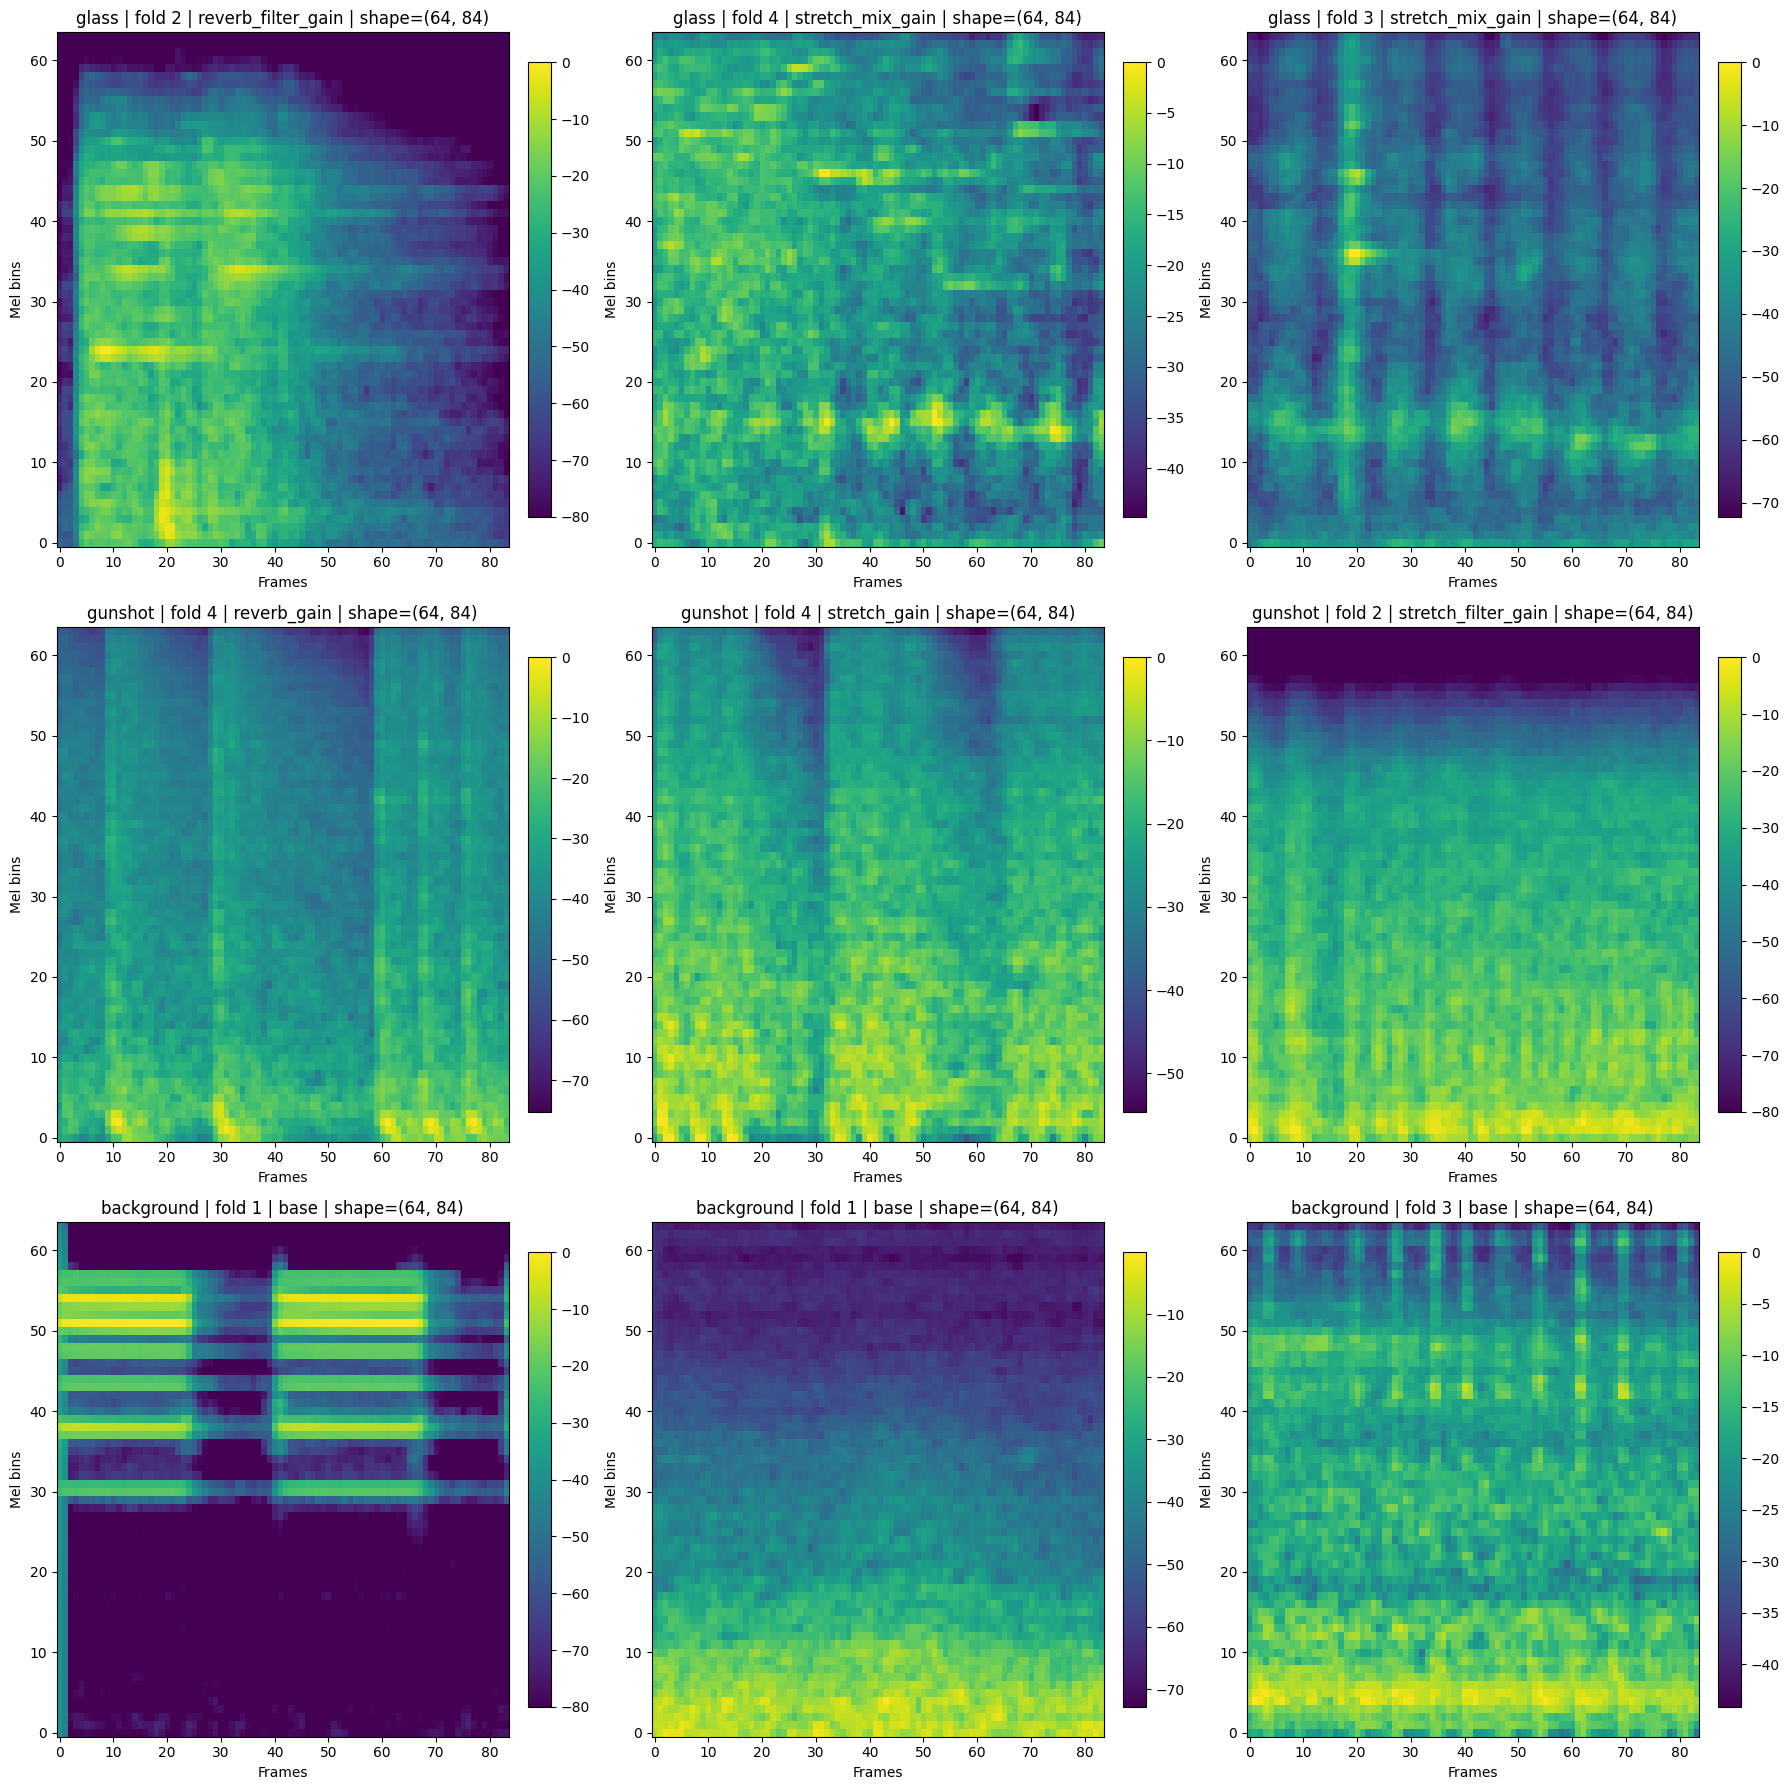

In [21]:
import matplotlib.pyplot as plt

def resolve_audio_from_row(row, sr=TARGET_SR):
    if 'audio' in row and row['audio'] is not None:
        return row['audio'], sr
    return load_audio(row, sr=sr)

samples_per_label = 3
labels = ['glass', 'gunshot', BACKGROUND_LABEL]
rows = []
rng = np.random.default_rng(SEED)

for lbl in labels:
    subset = all_windows_df[all_windows_df['target_label'] == lbl]
    if subset.empty:
        continue
    # 有放回抽样，确保凑够 samples_per_label
    picks = subset.sample(n=samples_per_label, replace=len(subset) < samples_per_label, random_state=None)
    rows.extend(picks.to_dict('records'))

if not rows:
    print("No samples available for plotting.")
else:
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.flatten()
    for idx, row in enumerate(rows[:9]):  # 防止不足 9 条
        y, sr = resolve_audio_from_row(row, sr=TARGET_SR)
        mel = log_mel_spectrogram(y, sr)
        if TARGET_FRAMES is not None:
            if mel.shape[1] > TARGET_FRAMES:
                mel = mel[:, :TARGET_FRAMES]
            elif mel.shape[1] < TARGET_FRAMES:
                pad = TARGET_FRAMES - mel.shape[1]
                mel = np.pad(mel, ((0, 0), (0, pad)), mode="constant")
        ax = axes[idx]
        im = ax.imshow(mel, origin='lower', aspect='auto')
        ax.set_title(
            f"{row.get('target_label','?')} | fold {row.get('fold_id','?')} | {row.get('pipeline','base')} | shape={mel.shape}"
        )
        ax.set_xlabel('Frames')
        ax.set_ylabel('Mel bins')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # 处理空格子
    for j in range(len(rows), 9):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()




## 缓存训练 window 的 mel-log 图谱，以及输出训练目录

In [22]:
from pathlib import Path
import numpy as np

cache_dir = CACHE_MEL64  # 或自定义 Path("cache/mel64_final")
index_csv = PROJECT_ROOT / "cache" / "window_index.csv"
cache_dir.mkdir(parents=True, exist_ok=True)

records = []
for _, row in all_windows_df.iterrows():
    # 取音频
    if 'audio' in row and row['audio'] is not None:
        y, sr = row['audio'], TARGET_SR
    else:
        y, sr = load_audio(row, sr=TARGET_SR)

    # 保存 mel
    label = row.get('target_label', BACKGROUND_LABEL)
    fold = int(row.get('fold_id', -1))
    clip_id = row.get('clip_id', Path(str(row.get('filepath',''))).stem)
    window_id = row.get('window_id', f"w{_}")
    out_dir = cache_dir / label / f"fold{fold}"
    out_dir.mkdir(parents=True, exist_ok=True)
    cache_path = out_dir / f"{clip_id}_{window_id}.npy"
    mel = log_mel_spectrogram(y, sr)
    if TARGET_FRAMES is not None:
        if mel.shape[1] > TARGET_FRAMES:
            mel = mel[:, :TARGET_FRAMES]
        elif mel.shape[1] < TARGET_FRAMES:
            pad = TARGET_FRAMES - mel.shape[1]
            mel = np.pad(mel, ((0, 0), (0, pad)), mode="constant")

    np.save(cache_path, mel.astype(np.float32))

    records.append({
        "path": str(cache_path.relative_to(PROJECT_ROOT)),
        "target_label": label,
        "fold_id": fold,
        "pipeline": row.get('pipeline', 'base'),
        "clip_id": clip_id,
        "window_id": window_id,
        "source": row.get('source', ''),
        "orig_label": row.get('original_label', row.get('orig_label', label)),
        "length_sec": row.get('length_sec', len(y)/sr),
    })

index_df = pd.DataFrame(records)
index_df.to_csv(index_csv, index=False)
print(f"Saved {len(index_df)} windows to {cache_dir}")
print(f"Index CSV: {index_csv}")
display(index_df.head())


Saved 4500 windows to /workspace/cache/mel64
Index CSV: /workspace/cache/window_index.csv


path target_label  fold_id  \
0  cache/mel64/glass/fold1/5-233607-A-39_5-233607...        glass        1   
1  cache/mel64/glass/fold1/1-85184-A-39_1-85184-A...        glass        1   
2  cache/mel64/glass/fold1/4-204119-A-39_4-204119...        glass        1   
3  cache/mel64/glass/fold1/1-20133-A-39_1-20133-A...        glass        1   
4  cache/mel64/glass/fold1/1-20133-A-39_1-20133-A...        glass        1   

  pipeline        clip_id         window_id source orig_label  length_sec  
0     base  5-233607-A-39  5-233607-A-39_w0  esc50      glass         1.0  
1     base   1-85184-A-39   1-85184-A-39_w0  esc50      glass         1.0  
2     base  4-204119-A-39  4-204119-A-39_w0  esc50      glass         1.0  
3     base   1-20133-A-39   1-20133-A-39_w0  esc50      glass         1.0  
4     base   1-20133-A-39   1-20133-A-39_w1  esc50      glass         1.0

In [23]:
from src.config import SEED, LABEL_TO_ID, BACKGROUND_LABEL, NUM_CLASSES

from pathlib import Path
import numpy as np
import pandas as pd

cache_dir = CACHE_MEL64  # 或 Path("cache/mel64_final")
index_csv = PROJECT_ROOT / "cache" / "window_index.csv"
cache_dir.mkdir(parents=True, exist_ok=True)

records = []
for _, row in all_windows_df.iterrows():
    # 音频获取
    if 'audio' in row and row['audio'] is not None:
        y, sr = row['audio'], TARGET_SR
    else:
        y, sr = load_audio(row, sr=TARGET_SR)

    # 标签/多标签
    tgt = row.get('target_label', BACKGROUND_LABEL)
    fold = int(row.get('fold_id', -1))
    clip_id = row.get('clip_id', Path(str(row.get('filepath', ''))).stem)
    window_id = row.get('window_id', f"w{_}")

    labels = [tgt] if tgt in TARGET_LABELS else []
    label_ids = [LABEL_TO_ID[l] for l in labels]
    main_label = labels[0] if labels else BACKGROUND_LABEL

    # 计算并裁剪/填充 mel
    mel = log_mel_spectrogram(y, sr)
    if TARGET_FRAMES is not None:
        if mel.shape[1] > TARGET_FRAMES:
            mel = mel[:, :TARGET_FRAMES]
        elif mel.shape[1] < TARGET_FRAMES:
            pad = TARGET_FRAMES - mel.shape[1]
            mel = np.pad(mel, ((0, 0), (0, pad)), mode="constant")

    # 保存 mel
    out_dir = cache_dir / main_label / f"fold{fold}"
    out_dir.mkdir(parents=True, exist_ok=True)
    cache_path = out_dir / f"{clip_id}_{window_id}.npy"
    np.save(cache_path, mel.astype(np.float32))

    records.append({
        "path": str(cache_path.relative_to(PROJECT_ROOT)),
        "target_label": tgt,
        "label": main_label,
        "labels": labels,
        "label_ids": label_ids,
        "fold_id": fold,
        "pipeline": row.get('pipeline', 'base'),
        "clip_id": clip_id,
        "window_id": window_id,
        "source": row.get('source', ''),
        "shape": mel.shape,
        "orig_label": row.get('original_label', row.get('orig_label', tgt)),
        "length_sec": row.get('length_sec', len(y) / sr),
    })

index_df = pd.DataFrame(records)
index_df.to_csv(index_csv, index=False)
print(f"Saved {len(index_df)} windows to {cache_dir}")
print(f"Index CSV: {index_csv}")
display(index_df.head())


Saved 4500 windows to /workspace/cache/mel64
Index CSV: /workspace/cache/window_index.csv


path target_label  label  \
0  cache/mel64/glass/fold1/5-233607-A-39_5-233607...        glass  glass   
1  cache/mel64/glass/fold1/1-85184-A-39_1-85184-A...        glass  glass   
2  cache/mel64/glass/fold1/4-204119-A-39_4-204119...        glass  glass   
3  cache/mel64/glass/fold1/1-20133-A-39_1-20133-A...        glass  glass   
4  cache/mel64/glass/fold1/1-20133-A-39_1-20133-A...        glass  glass   

    labels label_ids  fold_id pipeline        clip_id         window_id  \
0  [glass]       [0]        1     base  5-233607-A-39  5-233607-A-39_w0   
1  [glass]       [0]        1     base   1-85184-A-39   1-85184-A-39_w0   
2  [glass]       [0]        1     base  4-204119-A-39  4-204119-A-39_w0   
3  [glass]       [0]        1     base   1-20133-A-39   1-20133-A-39_w0   
4  [glass]       [0]        1     base   1-20133-A-39   1-20133-A-39_w1   

  source     shape orig_label  length_sec  
0  esc50  (64, 84)      glass         1.0  
1  esc50  (64, 84)      glass         1.0  
2  esc50  (64, 84)      glass         1.0  
3  esc50  (64, 84)      glass         1.0  
4  esc50  (64, 84)      glass         1.0

In [24]:
# 去重看有哪些组合
unique_combos = index_df['label_ids'].apply(tuple).unique()
print(unique_combos)

[(0,) (1,) ()]
